In [1]:
# Import custom module
import sys
import os
sys.path.insert(0,os.path.abspath("../scripts"))
import prediction as pre
import importlib
importlib.reload(pre)
import lstm_pipeline as lstm
import importlib
importlib.reload(lstm)

import logging
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Load a small sample to inspect data
train_sample = pd.read_csv('../data/train.csv', nrows=10)

# Check the data types
print(train_sample.dtypes)

# Inspect values in column 7 (replace with actual column index or name)
print(train_sample.iloc[:, 7].unique())

# Load the full dataset with the correct dtype for column 7
train = pd.read_csv('../data/train.csv', dtype={'StateHoliday': 'str'})  # Treat 'StateHoliday' as string


Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday      int64
SchoolHoliday     int64
dtype: object
[0]


In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', filename='../logs/rossmann_sales_forecast.log')
# Load the dataset
test = pre.load_data('../data/test.csv')

Pre-processing data

In [4]:
#  Apply feature engineering
train = pre.feature_engineering(train)
test = pre.feature_engineering(test)

In [5]:
# Handle missing values
train = pre.handle_missing(train)
test = pre.handle_missing(test)

In [6]:
# Prepare features and target
X_train = train.drop(columns=['Sales', 'Customers', 'Date', 'Store'])
y_train = train['Sales']
X_test = test.drop(columns=['Date', 'Store'])

In [7]:
# Encode categorical variables
X_train_encoded, X_test_encoded = pre.encode_categorical(X_train, X_test)

Building models with sklearn pipelines

In [8]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = pre.train_test_split(X_train_encoded, y_train, test_size=0.2, random_state=42)

In [9]:
# Train the model
model = pre.train_model(X_train_split, y_train_split)

c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [10]:
# Evaluate the model
pre.evaluate_model(model, X_val_split, y_val_split)

RMSE: 2444.1386896772933


In [11]:
test['PredictedSales'] = model.predict(X_test_encoded)

In [12]:
# Save predictions to a CSV file
test[['Id', 'PredictedSales']].to_csv('../data/predicted_sales.csv', index=False)
print("Predictions saved.")

Predictions saved.


Choose a loss function

Root Mean Squared Error (RMSE):

RMSE gives higher weight to large errors, making it suitable for cases where outliers or large deviations matter. Since you're predicting sales, having a few large errors could be detrimental to business planning, so RMSE is often a good choice.
Pros: Sensitive to large errors (e.g., over-predicting sales for a store by a large margin).
Cons: May overly penalize outliers.

In [13]:
# Make predictions for the validation set
y_pred = model.predict(X_val_split)
pre.calculate_rmse(y_val_split, y_pred)

RMSE: 2444.1386896772933


Post-Prediction Analysis

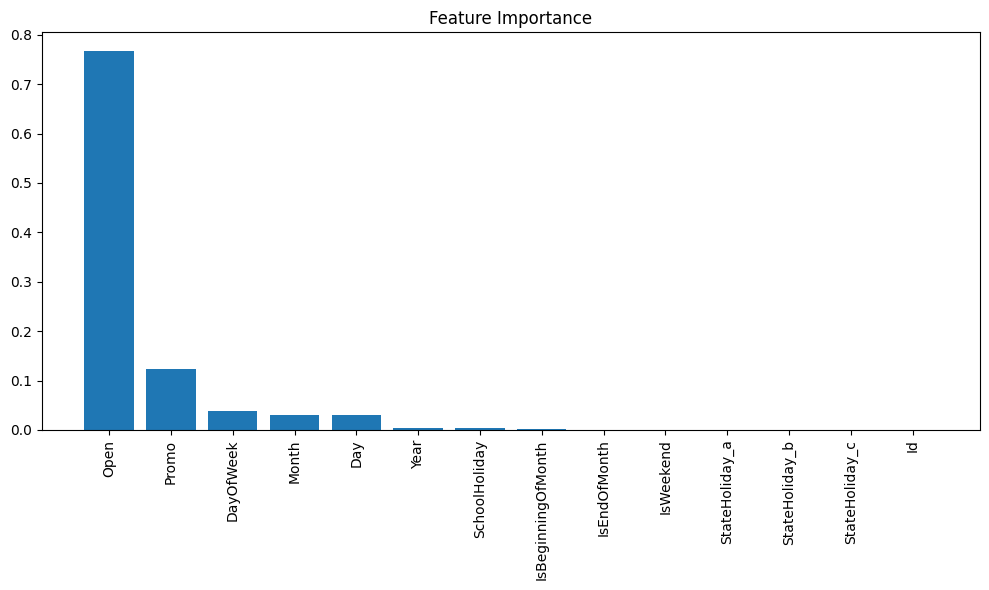

In [14]:
pre.plot_feature_importance(model, X_train_encoded)

Confidence Interval Estimation

In [15]:
# Downsample the training data to 10% of the original size for faster processing
train_sampled = train.sample(frac=0.1, random_state=42)
X_train_sampled = X_train_encoded.sample(frac=0.1, random_state=42)
y_train_sampled = y_train.sample(frac=0.1, random_state=42)

# Set the number of bootstrap iterations and the number of jobs for parallel processing
n_iterations = 10  # Start with fewer iterations
n_jobs = -1  # Use all available CPU cores
alpha = 0.95  # 95% confidence interval


# Call the bootstrap confidence interval function with parallel processing
lower_bound, upper_bound = pre.estimate_confidence_intervals(X_train_sampled, y_train_sampled, X_test_encoded, n_iterations, alpha, n_jobs)

# Print a few sample results
print("Sample predictions with confidence intervals:")
for i in range(5):  # Display only the first 5 samples
    print(f"Predicted Sales: {test['PredictedSales'][i]:.2f}, "
          f"95% CI: [{lower_bound[i]:.2f}, {upper_bound[i]:.2f}]")


Sample predictions with confidence intervals:
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]
Predicted Sales: 7013.80, 95% CI: [6804.80, 7184.19]


Serialize models

In [16]:
pre.serialize_model(model)

Model saved as ../models/sales_model_25-09-2024-18-53-49.pkl


Building model with deep learning 

Isolate Rossmann Store Sales Data for Time Series

In [17]:
# Isolate time series sales data for a specific store
store_sales = train[train['Store'] == 1]['Sales']

Check for stationarity

In [18]:
lstm.check_stationarity(store_sales)

ADF Statistic: -4.37478361258119, p-value: 0.0003288655352513879
The time series is stationary.


Plot autocorrelation and partial autocorrelation

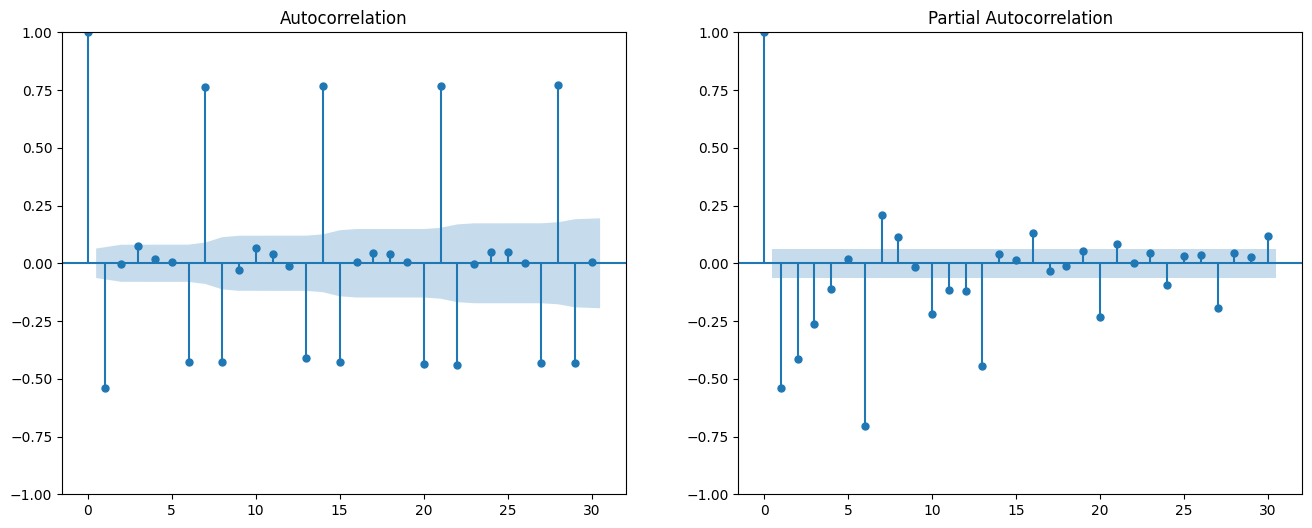

In [19]:
store_sales_diff = lstm.difference_data(store_sales)
lstm.plot_acf_pacf(store_sales_diff)

Transform the data into supervised learning format (sliding window)

In [20]:
n_lag = 10
X, y = lstm.create_supervised_data(store_sales_diff.values, n_lag)

Scale the data

In [21]:
X_scaled, y_scaled, scaler_X, scaler_y = lstm.scale_data(X, y)

Reshape X_scaled for LSTM input (samples, timesteps, features)

In [22]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

Build the LSTM model

In [23]:
model = lstm.build_lstm_model(X_scaled.shape[1:])

Train the model

In [24]:
history = lstm.train_lstm_model(model, X_scaled, y_scaled, epochs=10, batch_size=32)

Epoch 1/10
30/30 [==============================] - 4s 10ms/step - loss: 0.1124
Epoch 2/10
30/30 [==============================] - 0s 10ms/step - loss: 0.1022
Epoch 3/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0826
Epoch 4/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0623
Epoch 5/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0542
Epoch 6/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0554
Epoch 7/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0518
Epoch 8/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0505
Epoch 9/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0502
Epoch 10/10
30/30 [==============================] - 0s 10ms/step - loss: 0.0496


Save the model

In [25]:
lstm.save_model(model, name='sales_forecast', directory='../models')

Plot training history

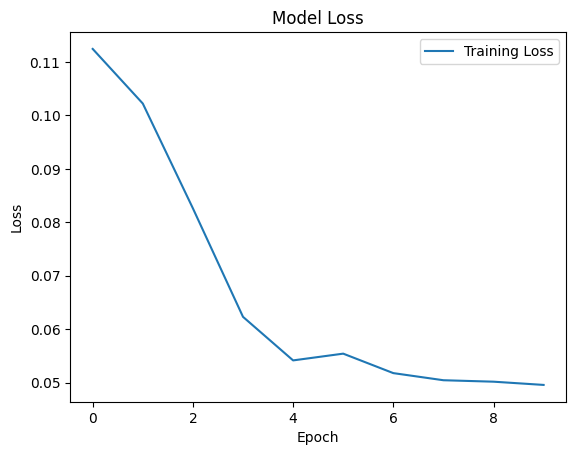

In [26]:
lstm.plot_loss(history)